# NTM - dataframes processing
### Enrico Gavagnin

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 9]
import rpy2.robjects as robjects

from rpy2.robjects.packages import importr
%load_ext rpy2.ipython

#df = pd.read_pickle('data/prop_data_gap_12_2_1_05_ct_NEST.pkl').drop_duplicates()
data_file_name = 'data/prop_data_6_4_2_1_ct_NEST.pkl'
df = pd.read_pickle(data_file_name).drop_duplicates()

#pv_effect_df = pd.DataFrame(columns=['exp', 'time_win (h)', 'link_type', 'pv/effect', 'cMOD', 'partition', 'wDIA', 'cwDEH', 'wDEN'])

if '_ni_' in data_file_name:
    link_type = '#inter'
elif '_ct_'in data_file_name:
    link_type = 'length_inter'

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Filtering

In [58]:
# --------- FILTERING ------------
reps_discarded = [20,41]
exp = 'MOD'

time_win = 6 #h
max_gap = 10 #s

df_filt = df.loc[(df.time_win==3600 * time_win) & 
                 (df.max_gap==max_gap) & 
                (df.exp.isin([exp+'a',exp+'b'])) & 
                (~df.rep.isin(reps_discarded))]
df_filt.insert(4,'h', [int(str(a)[-8:-6]) for a in df_filt.start])
df_filt = df_filt.sort_values(['rep','h'])

rep_to_colony = {i: i for i in range(57)}
#df_filt.insert(5, 'colony', [rep_to_colony[j] for j in df_filt.rep])

# Export dataframe for stats
df_filt.to_csv('NTM_df_stats.csv')

%R 

IndentationError: unexpected indent (85057075.py, line 30)

## Statistics

In [59]:
%%R -i time_win -o prop_list -o pv_adj 

stats_R <- function() {

    prop_list <- c('cMOD','partition','wDIA','cwDEH','wDEN')
    dat <- read.csv("NTM_df_stats.csv", header=T, stringsAsFactors = F)
      # list of properties for the LMER test
    pv_list <- integer(0)


    if (dat$time_win[1] == 12*3600){rf <- ' ~ exp +(1|rep)'}
        else{rf <- ' ~ exp +(1|rep)+(1|h)'}

    for (prop in prop_list){
        model <- lmer(formula(paste(prop,rf)), data = dat)
        print(summary(model))
        pv_list <- c(pv_list, as.numeric(Anova(model)["exp","Pr(>Chisq)"]))
    }

    pv_adj <- p.adjust(pv_list, method="BH")
    names(pv_adj) <- prop_list
  return(pv_adj)
}


# -----------------------------
# Linear Mixed Effects Model (R)
# -----------------------------
rm(list=ls())
library(lme4)
library(car)

prop_list <- c('cMOD','partition','wDIA','cwDEH','wDEN')
dat <- read.csv("NTM_df_stats.csv", header=T, stringsAsFactors = F)
  # list of properties for the LMER test
pv_list <- integer(0)


if (dat$time_win[1] == 12*3600){rf <- ' ~ exp +(1|rep)'}
    else{rf <- ' ~ exp +(1|rep)+(1|h)'}

for (prop in prop_list){
    model <- lmer(formula(paste(prop,rf)), data = dat)
    print(summary(model))
    pv_list <- c(pv_list, as.numeric(Anova(model)["exp","Pr(>Chisq)"]))
}

pv_adj <- p.adjust(pv_list, method="BH")
names(pv_adj) <- prop_list

print(pv_adj)

Linear mixed model fit by REML ['lmerMod']
Formula: cMOD ~ exp + (1 | rep) + (1 | h)
   Data: dat

REML criterion at convergence: -153.6

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.66338 -0.67127  0.01705  0.79543  1.99602 

Random effects:
 Groups   Name        Variance  Std.Dev. 
 rep      (Intercept) 9.894e-04 0.0314547
 h        (Intercept) 1.037e-09 0.0000322
 Residual             8.666e-04 0.0294383
Number of obs: 44, groups:  rep, 11; h, 2

Fixed effects:
            Estimate Std. Error t value
(Intercept) 0.229110   0.011373  20.146
expMODb     0.005227   0.008876   0.589

Correlation of Fixed Effects:
        (Intr)
expMODb -0.390
optimizer (nloptwrap) convergence code: 0 (OK)
Model failed to converge with max|grad| = 0.00719666 (tol = 0.002, component 1)

Linear mixed model fit by REML ['lmerMod']
Formula: partition ~ exp + (1 | rep) + (1 | h)
   Data: dat

REML criterion at convergence: 110.2

Scaled residuals: 
    Min      1Q  Median      3Q     Ma

R[write to console]: boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML ['lmerMod']
Formula: wDIA ~ exp + (1 | rep) + (1 | h)
   Data: dat

REML criterion at convergence: 187.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.7612 -0.5974 -0.4127  0.0647  3.0986 

Random effects:
 Groups   Name        Variance Std.Dev.
 rep      (Intercept) 0.000    0.000   
 h        (Intercept) 0.000    0.000   
 Residual             4.366    2.089   
Number of obs: 44, groups:  rep, 11; h, 2

Fixed effects:
            Estimate Std. Error t value
(Intercept)   1.6791     0.4455   3.769
expMODb      -0.1498     0.6300  -0.238

Correlation of Fixed Effects:
        (Intr)
expMODb -0.707
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see ?isSingular



R[write to console]: boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML ['lmerMod']
Formula: cwDEH ~ exp + (1 | rep) + (1 | h)
   Data: dat

REML criterion at convergence: 734.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.4694 -0.6761 -0.1077  0.7075  1.8308 

Random effects:
 Groups   Name        Variance Std.Dev.
 rep      (Intercept) 4686209  2164.8  
 h        (Intercept)       0     0.0  
 Residual              962463   981.1  
Number of obs: 44, groups:  rep, 11; h, 2

Fixed effects:
            Estimate Std. Error t value
(Intercept)  10421.3      685.4  15.205
expMODb        623.5      295.8   2.108

Correlation of Fixed Effects:
        (Intr)
expMODb -0.216
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see ?isSingular

Linear mixed model fit by REML ['lmerMod']
Formula: wDEN ~ exp + (1 | rep) + (1 | h)
   Data: dat

REML criterion at convergence: -488.7

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.74386 -0.48145 -0.01017  0.55303  1.76822 

Random

## Plotting
### (Properties distributions)

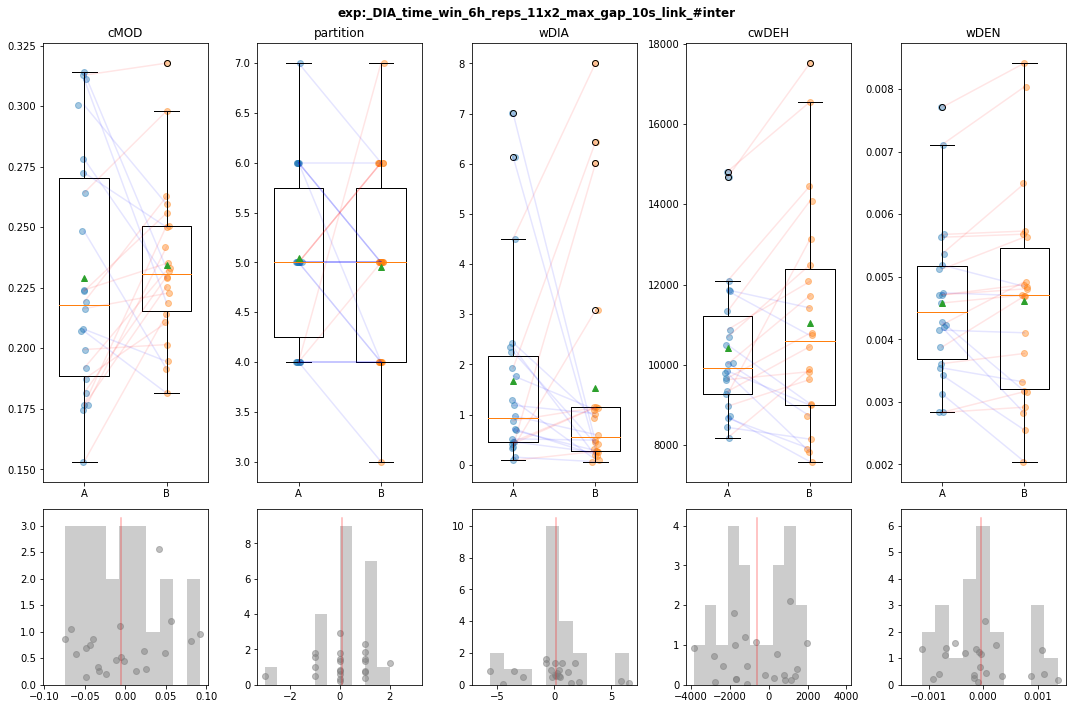

In [433]:
pv_dict = {prop_list[i]: pv_adj[i] for i in range(len(pv_adj))}
pv_dict
prop_list = list(pv_dict.keys())

# Save p values on the summary dataframe
pv_dict['exp'] = exp
pv_dict['time_win (h)'] = time_win
pv_dict['link_type'] = link_type
pv_dict['pv/effect'] = 'pv'
pv_effect_df = pd.concat([pv_effect_df, pd.DataFrame(pv_dict, index=[0])], ignore_index=True)

# Raw data specific property
fig, axs = plt.subplots(2, len(prop_list), 
                        gridspec_kw={'height_ratios': [2.5, 1]},
                        figsize=(15,10))

effect_dict = {}
for idx_p, p in enumerate(prop_list):

    # dataframe for a-b comparison
    df_ab = pd.DataFrame()
    df_ab.insert(0, 'A', list(df_filt[p].iloc[::2]))
    df_ab.insert(1, 'B', list(df_filt[p].iloc[1::2]))
    df_ab['A-B'] = df_ab.A-df_ab.B


    # Plotting
    vals, names, xs = [],[],[]
    for i, col in enumerate(['A', 'B']):
        vals.append(df_ab[col].values)
        names.append(col)
        xs.append(np.random.normal(i + 1, 0.02, df_ab[col].values.shape[0]))  # adds jitter to the data points - can be adjusted

    # box plot
    box_plot = axs[0,idx_p].boxplot(vals, labels=names, showmeans=True, widths=0.6)
    
    # scatter plot
    for x, val in zip(xs, vals):
        axs[0, idx_p].scatter(x, val, alpha=0.4)
    
    # step_line plot
    for idx_step_line in range(len(df_ab)):
        axs[0, idx_p].plot([1, 2], [df_ab.A.iloc[idx_step_line], df_ab.B.iloc[idx_step_line]], alpha=0.1,
                           color = 'r' if df_ab['A-B'].iloc[idx_step_line]<0 else 'b')

    means = df_ab.mean()
    stds =  df_ab.std()
    axs[0, idx_p].set_title(p)
    
    # statistical annotation
    
    if pv_dict[p]<=0.05:
        stat_sign = '*' + int(pv_dict[p]<=0.01)*'*' + int(pv_dict[p]<=0.001)*'*' + int(pv_dict[p]<=0.0001)*'*'
        x1, x2 = 1, 2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        mm =np.max(df_ab.max())
        y, h, col = 1.01*mm, 0.005*mm, 'k'
        axs[0, idx_p].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        axs[0, idx_p].text((x1+x2)*.5, y+h, stat_sign, ha='center', va='bottom', color=col, fontsize=17)
    
    # save effect 
    effect_dict[p] = df_ab['A-B'].mean() / df_ab['A-B'].std()
    
    # Histogram of difference
    axs[1, idx_p].hist(df_ab['A-B'],alpha=0.4, color = 'gray')
    axs[1, idx_p].scatter(df_ab['A-B'], abs(np.random.normal(0, 1, df_ab['A-B'].values.shape[0])), color = 'gray', alpha = 0.5)
    axs[1, idx_p].set_xlim([-1.1*np.max(abs(df_ab['A-B'])), 1.1*np.max(abs(df_ab['A-B']))])
    axs[1, idx_p].plot([df_ab['A-B'].mean(), df_ab['A-B'].mean()], [0, axs[1, idx_p].get_ylim()[1]], color='r', alpha = 0.3)
    plt.tight_layout()

    
# Save effects on the summary dataframe
effect_dict['exp'] = exp
effect_dict['time_win (h)'] = time_win
effect_dict['link_type'] = link_type
effect_dict['pv/effect'] = 'effect'
pv_effect_df = pd.concat([pv_effect_df, pd.DataFrame(effect_dict, index=[0])], ignore_index=True)



title = 'exp:_' + exp + '_time_win_' + str(time_win) + 'h' + '_reps_' + str(int(len(df_ab)*time_win/12)) + 'x' + str(int(12/time_win)) +  '_max_gap_' + str(max_gap) + 's_link_' + link_type
fig = plt.suptitle(title, fontweight="bold")
plt.tight_layout()
plt.savefig('plots/' + title + '.png', facecolor='white', transparent=False)
plt.show()

In [430]:
v = df_ab['A-B'] 
np.mean(v/np.std(v))

-0.05150422556021

In [380]:

# Export dataframe for stats
pv_effect_df.to_csv('data/pv_effect_df.csv')

pv_effect_df


,exp,time_win,link_type,pv/effect,cMOD,partition,wDIA,cwDEH,wDEN
0,DIA,1,#inter,pv,0.014711,0.505192,0.011522,0.355984,0.013932
1,DIA,1,#inter,effect,0.015314,-0.068182,-0.170912,1.939617,0.000015
2,DIA,2,#inter,pv,0.031834,0.714967,0.211708,0.211708,0.071189
3,DIA,2,#inter,effect,0.017079,-0.045455,-0.13223,5.626359,0.000015
4,DIA,4,#inter,pv,0.019327,0.353479,0.000391,0.352954,0.168987
...,...,...,...,...,...,...,...,...,...
59,MOD,2,length_inter,effect,-0.011825,0.439394,0.125012,-239.642325,-0.000034
60,MOD,4,length_inter,pv,0.69433,0.741418,0.522137,0.048851,0.741418
61,MOD,4,length_inter,effect,-0.006895,0.090909,0.61861,-432.067068,-0.000034
62,MOD,6,length_inter,pv,0.812096,0.812096,0.812096,0.175222,0.812096


## Plotting
### (Connectivity)

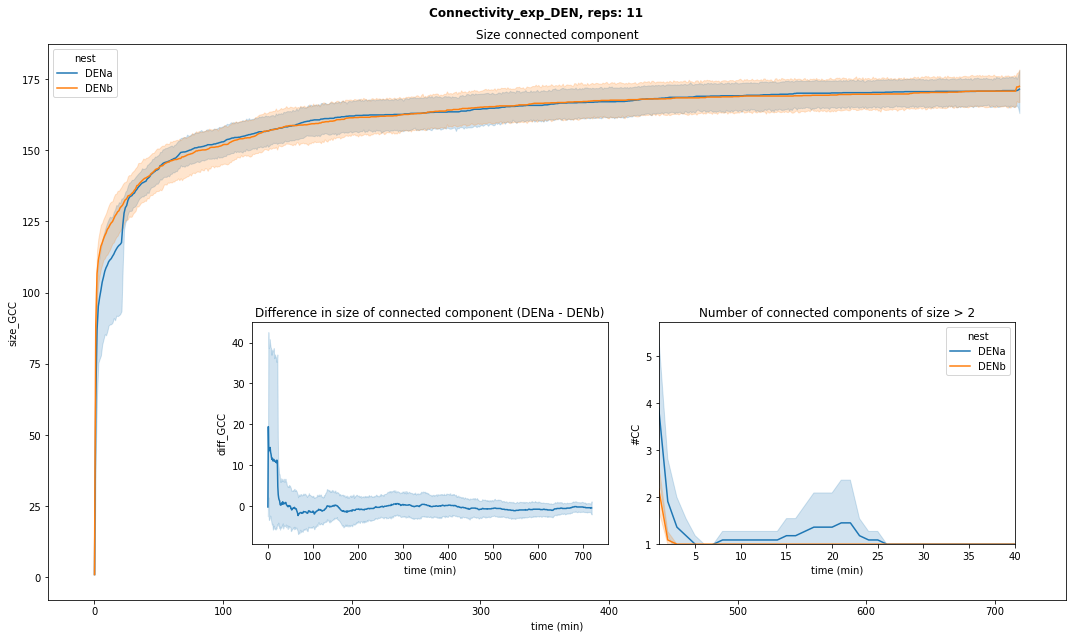

In [329]:
# Reading dataframe of connectivity
Gcc_df = pd.read_pickle('data/Gcc_NEST.pkl')

#Filter for the experiement of interest
Gcc_df = Gcc_df[Gcc_df.rep != 20]
Gcc_df = Gcc_df[[e[0:3] == exp for e in Gcc_df.exp]]
Gcc_df.sort_values(['rep','exp'])
connect_df = pd.DataFrame(columns=['rep', 'nest', 'time (min)', 'size_GCC', '#CC'])

# treshold minimal partition size
tresh_part = 2

# Reformatting dataframe
for row in range(len(Gcc_df)):
    df_aux = pd.DataFrame({'rep': [Gcc_df.rep.iloc[row]] * len(Gcc_df.Gcc.iloc[row][0]),
                          'nest': [Gcc_df.exp.iloc[row]] * len(Gcc_df.Gcc.iloc[row][0]),
                          'time (min)': Gcc_df.Gcc.iloc[row][1],
                          'size_GCC': [len(cc[0]) for cc in Gcc_df.Gcc.iloc[row][0]],
                          '#CC': [sum([len(p) > tresh_part for p in cc]) for cc in Gcc_df.Gcc.iloc[row][0]]})
    connect_df = pd.concat([connect_df, df_aux], ignore_index=True)
    
# Plotting    
fig, axs = plt.subplots(1, 1)
title = 'Connectivity_exp_' + exp + ', reps: ' + str(int(len(Gcc_df)/2)) 
supt = plt.suptitle(title, fontweight="bold")
# Plot 1 (size GCC)
sns.lineplot(data=connect_df, x="time (min)", y="size_GCC", hue="nest", ax=axs)
axs.set_title('Size connected component')
plt.tight_layout()
axs_i_r = axs.inset_axes([0.6,0.1,0.35,0.4])

# Plot 1 (number CC)
sns.lineplot(data=connect_df, x="time (min)", y="#CC", hue="nest", ax=axs_i_r)
axs_i_r.set_title('Number of connected components of size > ' + str(tresh_part))
axs_i_r.set_xlim([1,40])
axs_i_r.set_ylim(bottom=1)
plt.tight_layout()

# ====================================
# Difference in size of GCC
diff_connect_df = pd.DataFrame(columns=['rep', 'time (min)', 'diff_GCC'])

def diff_list_GCC(A, B):
    A_len = [len(a) for a in A]
    B_len = [len(b) for b in B]
    return [A_len[i] - B_len[i] for i in range(min(len(A), len(B)))]
    
# Reformatting dataframe
for row in range(0, len(Gcc_df) -1, 2):
    diff_GCC = diff_list_GCC(Gcc_df.Gcc.iloc[row][0], Gcc_df.Gcc.iloc[row + 1][0])
    df_aux = pd.DataFrame({'rep': [Gcc_df.rep.iloc[row]] * len(diff_GCC),
                          'time (min)': range(len(diff_GCC)),
                          'diff_GCC': diff_GCC})
    diff_connect_df = pd.concat([diff_connect_df, df_aux], ignore_index=True)

# Plotting    
# Plot 3 (diff size GCC)
axs_i_l = axs.inset_axes([0.2,0.1,0.35,0.4])
sns.lineplot(data=diff_connect_df, x="time (min)", y="diff_GCC", ax=axs_i_l)
axs_i_l.set_title('Difference in size of connected component (' + Gcc_df.exp.iloc[0] + ' - ' + Gcc_df.exp.iloc[1] + ')')
plt.tight_layout()

#Savefig
plt.savefig('plots/' + title + '.png', facecolor='white', transparent=False)



## Plotting
### (Relative difference)

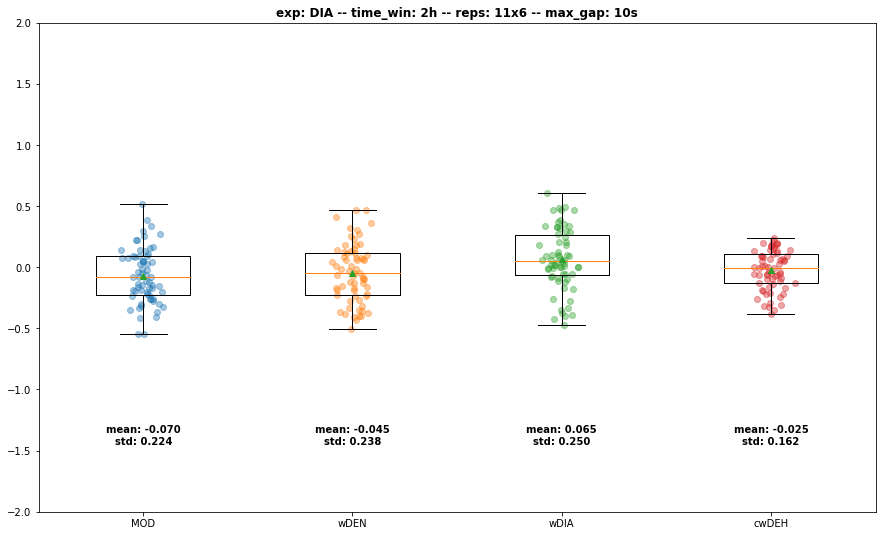

In [231]:
#===== RELATIVE DIFFERENCE =====


# ---- dataframe of relative difference---- 
p = ['MOD', 'wDEN', 'wDIA', 'cwDEH']
df_rd = (df_filt[p].diff()/df_filt[p].rolling(2).mean()).iloc[1::2]
df_rd.insert(0,'rep', df_filt.rep.iloc[1::2])
df_rd.insert(1,'exp', [a[0:3] for a in df_filt.exp.iloc[1::2]])
df_rd.insert(3,'start-b', list(df_filt.start.iloc[1::2]))

vals, names, xs = [],[],[]
for i, col in enumerate(df_rd[p].columns):
    vals.append(df_rd[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1, 0.04, df_rd[col].values.shape[0]))  # adds jitter to the data points - can be adjusted

plt.figure()
box_plot = plt.boxplot(vals, labels=names, showmeans=True)
for x, val in zip(xs, vals):
    plt.scatter(x, val, alpha=0.4)

means = df_rd[p].mean()
stds =  df_rd[p].std()

for xtick in range(len(p)):
    plt.text(xtick+1,-1.35, 'mean: {:.3f}'.format(means[xtick]), 
              horizontalalignment='center',size='medium',color='k',weight='semibold')
    plt.text(xtick+1,-1.45, 'std: {:.3f}'.format(stds[xtick]), 
                  horizontalalignment='center',size='medium',color='k',weight='semibold')

plt.ylim([-2,2])
fig = plt.title('exp: ' + exp + 
                ' -- time_win: ' + str(time_win) + 'h'
                ' -- reps: ' + str(int(len(df_rd)*time_win/12)) + 'x' + str(int(12/time_win)) + 
                ' -- max_gap: ' + str(max_gap) + 's',
               fontweight="bold")

## p-values & effeclength_intert visualisation

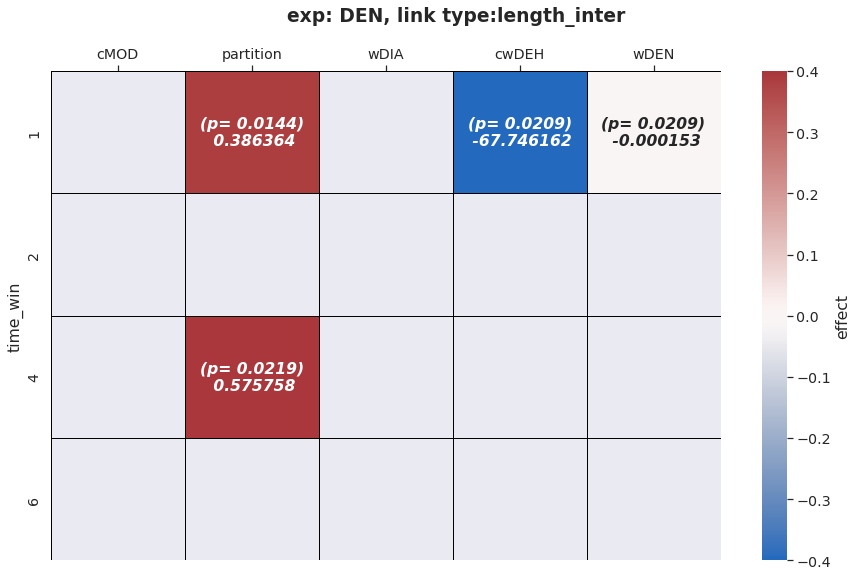

In [45]:
pv_effect_df = df = pd.read_csv('data/pv_effect_df_1444_29032022.csv', index_col=0)

exp = 'DEN'
link_type = 'length_inter' # '#inter' or 'length_inter'
pv_df = pv_effect_df[(pv_effect_df.exp == exp) & 
                     (pv_effect_df['pv/effect'] == 'pv') & 
                     (pv_effect_df['link_type'] == link_type)
                    ].drop(columns=['exp','link_type','pv/effect']).set_index('time_win')

effect_df = pv_effect_df[(pv_effect_df.exp == exp) & 
                         (pv_effect_df['pv/effect'] == 'effect') & 
                         (pv_effect_df['link_type'] == link_type)
                        ].drop(columns=['exp','link_type','pv/effect']).set_index('time_win')

effect_df[pv_df>0.05] = np.nan

# Annotation
sns.set(font_scale = 1.3)
annot = pv_df.copy()

for i in range(np.shape(annot)[0]):
    for j in range(np.shape(annot)[1]):
        annot.iloc[i,j] = '(p= {:.4f})\n {:f}'.format(annot.iloc[i,j], effect_df.iloc[i,j])
                
annot[pv_df>0.05] = ''
ax = sns.heatmap(effect_df, 
                 linewidths=1,
                 linecolor='black',
                 cmap='vlag',
                 center=0,
                 vmin=-0.4,
                 annot_kws={"style": "italic", "weight": "bold"},
                 vmax=0.4,
                 annot = annot, fmt = '',
                 cbar_kws={'label': 'effect'})
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
title = 'exp: ' + exp + ', link type:' + link_type
fig = plt.suptitle(title, fontweight="bold")


In [7]:
np.shape(annot)

(4, 5)

,cMOD,partition,wDIA,cwDEH,wDEN
time_win,,,,,
1,0.015314,0.0,-0.170912,0.0,0.000015
2,0.017079,0.0,0.000000,0.0,0.000000
4,0.017535,0.0,-0.317354,0.0,0.000000
6,0.000000,0.0,0.000000,0.0,0.000000
